In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gudhi as gd
import json

from glob import glob
import os
import tifffile as tf

from scipy import ndimage
from sklearn import manifold, cluster, decomposition, preprocessing

In [2]:
N = 10
color = ['#009e73', '#f0e442', '#0072b2', '#cc79a7']
color = dict(zip(range(N*len(color)), np.tile(color,N)))
color[-1] = '#000000'

marker = ['D', 'o', 's', '^', 'v', 'P']
marker = dict(zip(range(N*len(marker)), np.tile(marker,N)))
marker[-1] = '*'

levels = ['sublevel', 'superlevel']
gsrc = '../gudhi/'
sample = 'B1'
tsrc = gsrc + sample + '/'
transcriptomes = sorted([foo.split('/')[-2] for foo in glob(tsrc + '*/')])
print(len(transcriptomes), 'transcriptomes')

27 transcriptomes


In [3]:
wall = 255 - tf.imread('../cell_dams/' + sample + '_dams.tif')
wcoords = np.array(np.nonzero(wall))
#label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))
#objss = ndimage.find_objects(label)

In [4]:
filename = '../data/' + sample + '_data/' + transcriptomes[0] + '/' + transcriptomes[0] + ' - localization results by cell.csv'
print(filename)
df = pd.read_csv(filename)
df = df.iloc[~np.any(df.iloc[:, :5].isnull().values, axis=1)]
df = df.astype({'Cell.ID..':int})
df.head()

../data/B1_data/CYP93A1/CYP93A1 - localization results by cell.csv


,Cell.ID..,X.location,Y.location,Bouding.box.X,Bouding.box.Y,Bouding.box.width,Bouding.box.height,Cell.Area..px.,Nucleus.Area..px.,Total.transcript..,...,Median.distance.from.nucleus.incl..nucleus..px.,Median.distance.from.nucleus.excl..nucleus..px.,X1st.quartile.distance.w..nucleus..px.,X1st.quartile.distance.w.o.nucleus..px.,X3rd.quartile.distance.w..nucleus..px.,X3rd.quartile.distance.w.o.nucleus..px.,nuclear.only.transcripts,average.nuclear.transcript.percentage,Total.cells.expressed,Nuc_cells_exp
0,0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,159948015.0,66.0,...,202.0,222.0,101.0,122.0,357.0,378.0,5.0,7.6,327,122
1,1,7209.574,7213.375,0.0,0.0,10720.0,15008.0,63530175.0,182824.0,691.0,...,106.0,142.0,10.0,68.0,216.0,256.0,142.0,20.5,327,122
2,2,2495.503,1067.266,2344.0,905.0,271.0,324.0,53837.0,0.0,5.0,...,108.0,108.0,91.0,91.0,154.0,154.0,0.0,0.0,327,122
3,3,2524.642,1392.115,2064.0,961.0,961.0,849.0,390626.0,1246.0,32.0,...,143.0,153.0,64.0,72.0,202.0,202.0,1.0,3.1,327,122
4,4,3136.522,1323.289,2979.0,1131.0,286.0,386.0,69756.0,0.0,4.0,...,329.0,329.0,303.0,303.0,381.0,381.0,0.0,0.0,327,122


In [5]:
def get_diagrams(jsonfiles):
    diagh0 = [ np.empty((0,2)) for i in range(len(jsonfiles)) ]
    diagh1 = [ np.empty((0,2)) for i in range(len(jsonfiles)) ]

    for i in range(len(jsonfiles)):
        with open(jsonfiles[i]) as f:
            diag = [tuple(x) for x in json.load(f)]
        h1mask = np.sum([ diag[j][0] == 1 for j in range(len(diag)) ])
        diagh0[i] = np.asarray( [ x[1] for x in diag[h1mask:] ] )
        if h1mask > 0:
            diagh1[i] = np.asarray( [ x[1] for x in diag[:h1mask] ] )

    return diagh0, diagh1

def bottleneck_matrix(diagh0, diagh1):
    bottleneck_h0 = np.zeros( (len(diagh0), len(diagh0)) )
    bottleneck_h1 = np.zeros( (len(diagh0), len(diagh0)) )
    
    for i in range(len(bottleneck_h0) - 1):
        for j in range(i+1, len(bottleneck_h0)):
    
            ## H0 ##
            d = gd.bottleneck_distance(diagh0[i], diagh0[j])
            bottleneck_h0[i,j] = d
            bottleneck_h0[j,i] = d
    
            ## H1 ##
            d = gd.bottleneck_distance(diagh1[i], diagh1[j])
            bottleneck_h1[i,j] = d
            bottleneck_h1[j,i] = d
    
    bottleneck = np.where(bottleneck_h0 > bottleneck_h1, bottleneck_h0, bottleneck_h1)

    return bottleneck, bottleneck_h0, bottleneck_h1

In [6]:
if False:
    
    supjsons = sorted(glob(tsrc + transcriptomes[tidx] + '/superlevel*.json'))
    subdiagh0, subdiagh1 = get_diagrams(subjsons)
    supdiagh0, supdiagh1 = get_diagrams(supjsons)
    
    subbottle, subbottle_h0, subbottle_h1 = bottleneck_matrix(subdiagh0, subdiagh1)
    supbottle, supbottle_h0, supbottle_h1 = bottleneck_matrix(supdiagh0, supdiagh1)
    
    ## Sublevel persistence ##
    filename = tsrc + transcriptomes[tidx] + '/' + transcriptomes[tidx] + '_-_sublevel_bottleneck_h0.npy'
    np.save(filename, subbottle_h0, allow_pickle=True)
    filename = tsrc + transcriptomes[tidx] + '/' + transcriptomes[tidx] + '_-_sublevel_bottleneck_h1.npy'
    np.save(filename, subbottle_h1, allow_pickle=True)
    
    print(filename)
    
    ## Superlevel persistence ##
    filename = tsrc + transcriptomes[tidx] + '/' + transcriptomes[tidx] + '_-_superlevel_bottleneck_h0.npy'
    np.save(filename, supbottle_h0, allow_pickle=True)
    filename = tsrc + transcriptomes[tidx] + '/' + transcriptomes[tidx] + '_-_superlevel_bottleneck_h1.npy'
    np.save(filename, supbottle_h1, allow_pickle=True)
    
    print(filename)

In [7]:
tidx = 10
print(transcriptomes[tidx])
subjsons = sorted(glob(tsrc + transcriptomes[tidx] + '/sublevel*.json'))
print('Cells:', len(subjsons))

bottle_h0 = dict()
bottle_h1 = dict()

for key in levels:
    filename = tsrc + transcriptomes[tidx] + '/' + transcriptomes[tidx] + '_-_' + key + '_bottleneck_h0.npy'
    bottle_h0[key] = np.load(filename, allow_pickle=True)

for key in levels:
    filename = tsrc + transcriptomes[tidx] + '/' + transcriptomes[tidx] + '_-_' + key + '_bottleneck_h1.npy'
    bottle_h1[key] = np.load(filename, allow_pickle=True)
    
bottle = dict()
for key in levels:
    bottle[key] = np.where(bottle_h0[key] > bottle_h1[key], bottle_h0[key], bottle_h1[key])

GLYMA_06G065000
Cells: 60


In [8]:
mds_params = {'n_components':2, 'metric':True, 'random_state':42, 'dissimilarity':'precomputed', 'normalized_stress':False}
mds = dict()

for key in levels:
    mds[key] = manifold.MDS(**mds_params).fit_transform(bottle[key])

In [9]:
dbscan_params = {'eps':10, 'min_samples':3}
clust = dict()

for key in levels:
    clust[key] = cluster.DBSCAN(**dbscan_params).fit(mds[key][:,:2])

In [27]:
data = dict()
for key in levels:
    data[key] = pd.DataFrame(mds[key], columns=['MDS1', 'MDS2'])
    labs = clust[key].labels_
    scaler = preprocessing.StandardScaler().fit(mds[key][labs > -1])
    train = scaler.transform(mds[key])
    #PCA = decomposition.KernelPCA(n_components=1, random_state=42, kernel='rbf', gamma=0.01).fit(train[labs > -1])
    PCA = decomposition.PCA(n_components=1, random_state=42, whiten=False).fit(train[labs > -1])
    colors = PCA.transform(train).squeeze()
    data[key]['DBSCAN'] = labs
    data[key]['PCA1'] = colors

    indices = np.asarray([ os.path.splitext(subjsons[i])[0].split('_-_')[-2:] for i in range(len(subjsons)) ]).astype(int)
    data[key] = data[key].join(pd.DataFrame(indices, columns=['InternalID','ExternalID']))
    data[key] = data[key].join(df.loc[indices[:,0], ['X.location', 'Y.location']].reset_index(drop=True))
    data[key] = data[key].iloc[:, [4,5,6,7,0,1,3,2]]

meta = dict()
for key in levels:
    labs = clust[key].labels_
    ulabs, cts = np.unique(labs, return_counts=True)
    if -1 in ulabs:
        ulabs = np.hstack(([-1], ulabs[1:][np.argsort(cts[1:])[::-1]]))
    else:
        ulabs = ulabs[np.argsort(cts)[::-1]]
    meta[key] = {'vmin': np.min(data[key][data[key]['DBSCAN'] > -1 ]['PCA1']),
                 'vmax': np.max(data[key][data[key]['DBSCAN'] > -1 ]['PCA1']),
                 'labels': ulabs
                }

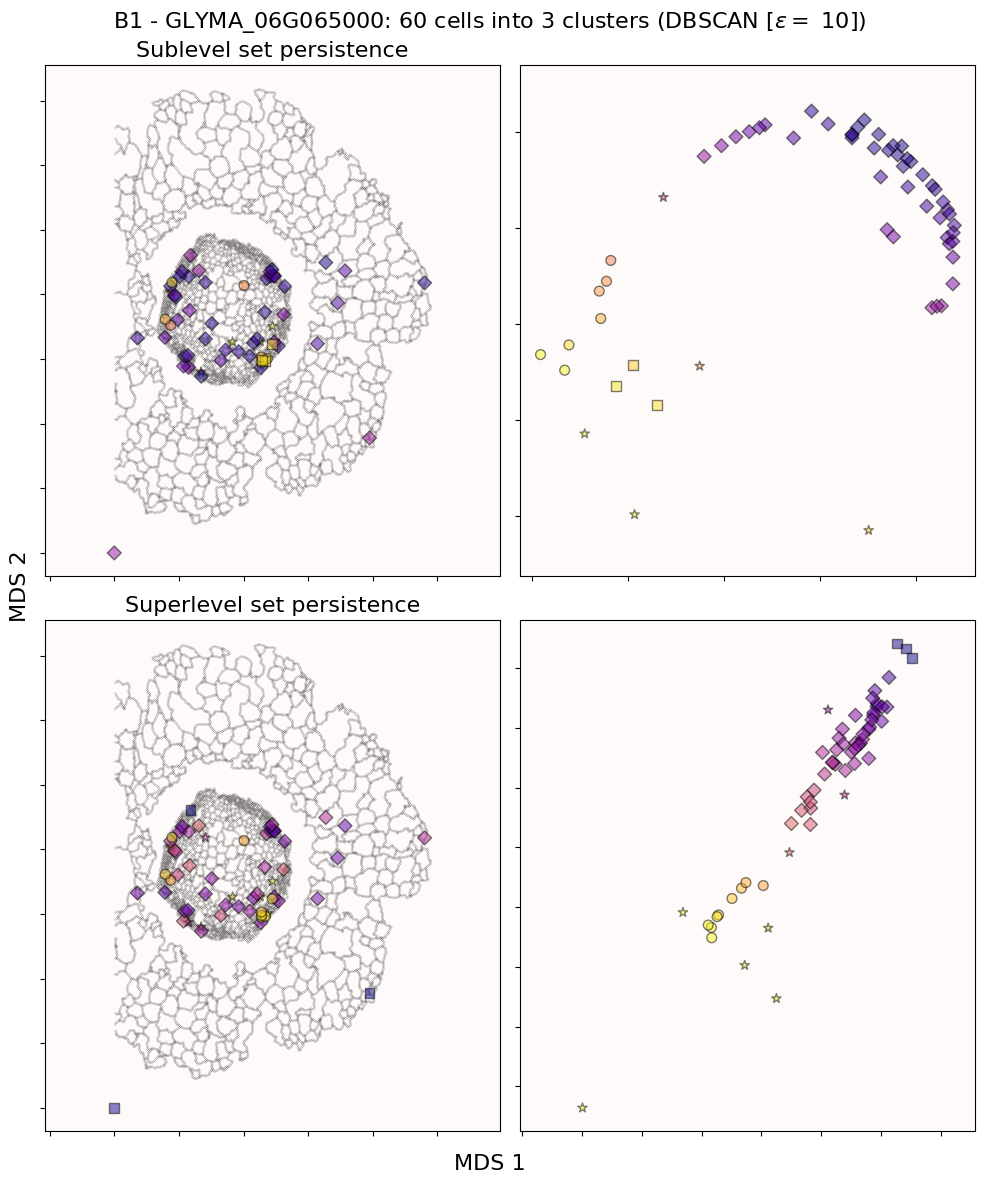

In [29]:
fs = 16
fig, ax = plt.subplots(2,2, figsize=(10,12))
ax = np.atleast_1d(ax).ravel()

for i,key in enumerate(levels):
    ax[2*i].scatter(wcoords[1], wcoords[0], c='gray', marker='.', s=0.01, zorder=1, alpha=0.1)
    
    for j in range(len(meta[key]['labels'])):
        label = meta[key]['labels'][j]
        order = j-1
        foo = data[key][data[key]['DBSCAN'] == label]
        ax[2*i].scatter(foo['X.location'], foo['Y.location'], s=50, edgecolor='k',
                        vmax=meta[key]['vmax'], vmin=meta[key]['vmin'],
                      c=foo['PCA1'], marker=marker[order], cmap='plasma', alpha=0.5, zorder = label+3)
        ax[2*i+1].scatter(foo['MDS1'], foo['MDS2'], s=50, alpha=0.5, vmax=meta[key]['vmax'], vmin=meta[key]['vmin'],
                      c=foo['PCA1'], marker=marker[order], edgecolor='k', cmap='plasma')
        
    
    ax[2*i].set_title(key.title() + ' set persistence', fontsize=fs)

for i in range(len(ax)):
    ax[i].set_aspect('equal', 'datalim');
    ax[i].set_facecolor('snow')
    ax[i].tick_params(labelbottom=False, labelleft=False)
    
fig.supxlabel('MDS 1', fontsize=fs)
fig.supylabel('MDS 2', fontsize=fs)

title = sample + ' - ' + transcriptomes[tidx]
title += ': {} cells into {} clusters (DBSCAN [$\\varepsilon = $ {}])'.format(len(subjsons), len(ulabs)-1, dbscan_params['eps'])
fig.suptitle(title, fontsize=fs)

fig.tight_layout();

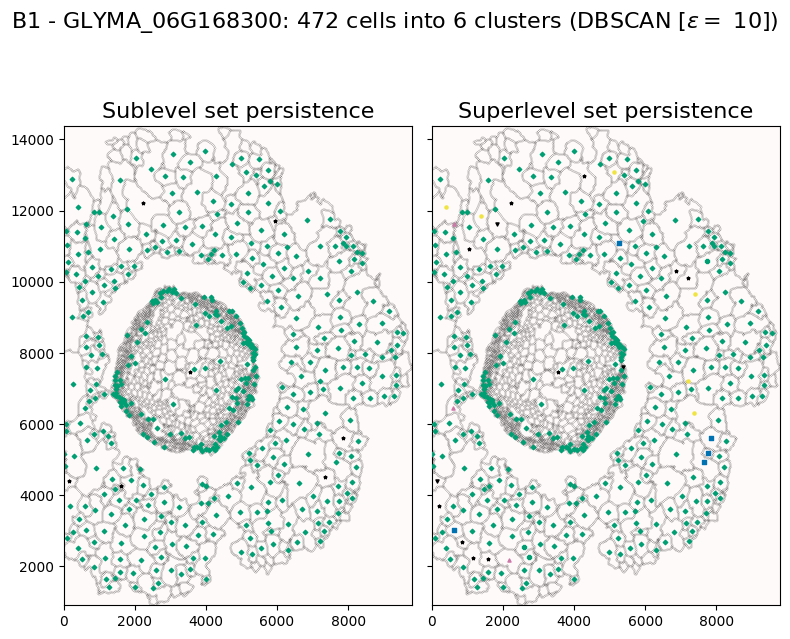

In [115]:
fig, ax = plt.subplots(1,2, figsize=(8,7), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i,key in enumerate(levels):
    ax[i].scatter(wcoords[1], wcoords[0], c='gray', marker='.', s=0.01, zorder=1, alpha=0.1)
    cellloc = cloc[key]
    
    for j in range(len(cellloc)):
        ax[i].scatter(cellloc[j][:,0], cellloc[j][:,1], s=5,
                      c=color[j%len(color)], marker=marker[j%len(marker)], zorder = len(cellloc) - j)
    
    ax[i].set_title(key.title() + ' set persistence', fontsize=fs)
    ax[i].set_aspect('equal')
    ax[i].margins(0)
    ax[i].set_facecolor('snow')

title = sample + ' - ' + transcriptomes[tidx] + ': {} cells into {} clusters (DBSCAN [$\\varepsilon = $ {}])'.format(len(subjsons), len(ulabs)-1, dbscan_params['eps'])
fig.suptitle(title, fontsize=fs)
fig.tight_layout();

In [118]:
cellloc

[array([[ 3546,  7472],
        [ 1611,  4244],
        [  143,  4395],
        [ 7351,  4505],
        [ 7845,  5593],
        [ 5932, 11692],
        [ 2223, 12203]]),
 array([[ 7209,  7213],
        [ 2524,  1392],
        [ 1279,  1412],
        [ 2010,  1427],
        [ 2651,  1532],
        [ 1192,  1642],
        [ 3013,  1889],
        [ 3313,  1780],
        [ 3996,  1643],
        [  867,  1973],
        [ 1952,  1802],
        [ 1453,  1676],
        [ 1590,  1839],
        [ 2598,  1887],
        [ 3545,  1923],
        [ 3961,  2246],
        [ 1173,  2237],
        [ 2178,  2189],
        [ 4994,  2407],
        [ 1583,  2196],
        [  519,  2214],
        [ 3639,  2246],
        [ 2725,  2271],
        [ 5300,  2358],
        [  411,  2524],
        [ 3046,  2624],
        [ 3450,  2556],
        [ 6301,  2463],
        [ 5874,  2619],
        [ 5562,  2514],
        [ 2583,  2550],
        [ 1618,  2649],
        [ 6797,  2952],
        [ 6555,  2679],
        [ 2259

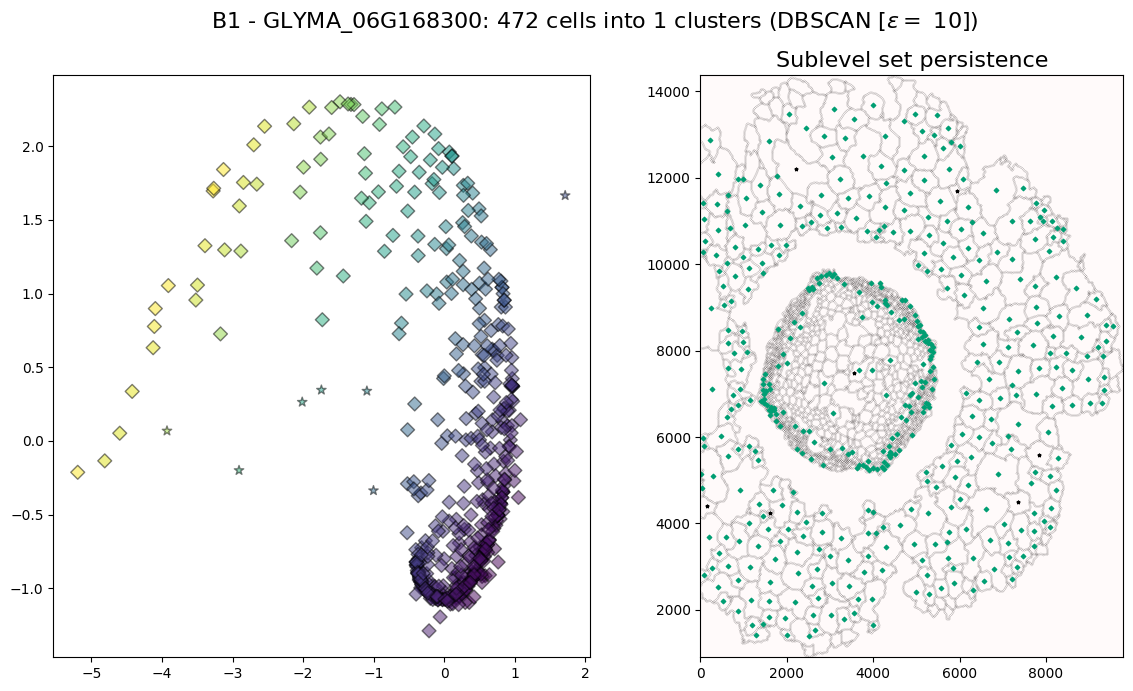

In [117]:
fig, ax = plt.subplots(1,2, figsize=(12,7))
ax = np.atleast_1d(ax).ravel()
key = 'sublevel'
labs = clust[key].labels_
ulabs, cts = np.unique(labs, return_counts=True)
if -1 in ulabs:
    ulabs = np.hstack(([-1], ulabs[1:][np.argsort(cts[1:])[::-1]]))
else:
    ulabs = ulabs[np.argsort(cts)[::-1]]
scaler = preprocessing.StandardScaler().fit(mds[key][labs > -1])
train = scaler.transform(mds[key])
KPCA = decomposition.PCA(n_components=1, random_state=42, whiten=False).fit(train[labs > -1])
kpca = KPCA.transform(train).squeeze()
vmax = np.max(kpca)
vmin = np.min(kpca)

i = 0
for j in range(len(ulabs)):
    mask = labs == ulabs[j]
    ax[i].scatter(train[mask,0], train[mask,1], s=50, alpha=0.5, vmax=vmax, vmin=vmin,
                  c=kpca[mask], marker=marker[j%len(marker)], edgecolor='k')

i = 1
ax[i].scatter(wcoords[1], wcoords[0], c='gray', marker='.', s=0.01, zorder=1, alpha=0.1)
cellloc = cloc[key]
for j in range(len(cellloc)):
    ax[i].scatter(cellloc[j][:,0], cellloc[j][:,1], s=5,
                  c=, marker=marker[j%len(marker)], zorder = len(cellloc) - j)
    
    ax[i].set_title(key.title() + ' set persistence', fontsize=fs)
    ax[i].set_aspect('equal')
    ax[i].margins(0)
    ax[i].set_facecolor('snow')

title = sample + ' - ' + transcriptomes[tidx] + ': {} cells into {} clusters (DBSCAN [$\\varepsilon = $ {}])'.format(len(subjsons), len(ulabs)-1, dbscan_params['eps'])
fig.suptitle(title, fontsize=fs)
fig.tight_layout();

In [13]:
#from bokeh.plotting import ColumnDataSource, figure, output_file, show
#from bokeh.io import output_notebook, show
#from bokeh.models import TapTool, HoverTool

from bokeh import plotting as bkplt
from bokeh import io as bkio
from bokeh import models as bkmodels

bkio.output_notebook()

Loading BokehJS ...

In [14]:
TOOLTIPS = """
    <div>
        <div>
            <img
                src="@imgs" alt="@imgs" width="200"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

In [15]:
wallsource = bkplt.ColumnDataSource(data={'x':wcoords[1], 'y':wcoords[0]})

In [16]:
# /home/eah4d/documents/mcarto/proc/B1/CYP93A1/diagnostic_CYP93A1_-_00000_-_00001.jpg
imgsrc = '../proc/' + sample + '/' + transcriptomes[tidx] + '/diagnostic_' + transcriptomes[tidx] + '_-_'

cds = [None for j in range(len(cloc[key])) ]

for j in range(len(cds)):
    foo = [ imgsrc + '{}_-_{}.jpg'.format(*cid[key][j][i]) for i in range(len(cid[key][j])) ]
    cds[j] = bkplt.ColumnDataSource(data={'x':cloc[key][j][:,0], 'y':cloc[key][j][:,1], 'imgs':foo})

In [17]:
cds[0].data

{'x': array([2638, 3627, 2785, 4422, 4570, 4614, 2246, 2300]),
 'y': array([5879, 5860, 6108, 6625, 6747, 6990, 8174, 8550]),
 'imgs': ['../proc/B1/GLYMA_06G065000/diagnostic_GLYMA_06G065000_-_302_-_317.jpg',
  '../proc/B1/GLYMA_06G065000/diagnostic_GLYMA_06G065000_-_348_-_363.jpg',
  '../proc/B1/GLYMA_06G065000/diagnostic_GLYMA_06G065000_-_427_-_441.jpg',
  '../proc/B1/GLYMA_06G065000/diagnostic_GLYMA_06G065000_-_601_-_616.jpg',
  '../proc/B1/GLYMA_06G065000/diagnostic_GLYMA_06G065000_-_608_-_623.jpg',
  '../proc/B1/GLYMA_06G065000/diagnostic_GLYMA_06G065000_-_708_-_724.jpg',
  '../proc/B1/GLYMA_06G065000/diagnostic_GLYMA_06G065000_-_1028_-_1045.jpg',
  '../proc/B1/GLYMA_06G065000/diagnostic_GLYMA_06G065000_-_1084_-_1101.jpg']}

In [18]:
#marker = ['*', 'D', 'o', 's', '^', 'v', 'P']
bkmarker = ['star', 'diamond', 'circle', 'square', 'triangle', 'inverted_triangle', 'plus']

In [31]:
j = 0

bkplt.output_file("barplot.html")
p = bkplt.figure(height=900, aspect_scale = 1, title=title)
p.scatter(x='x', y='y', size=1, color="gray", marker='dot', alpha=1, source=wallsource)
#p.scatter(x='x', y='y', size=10, color=color[j], marker=bkmarker[j], alpha=1, source=cds[j], name='plt_{}'.format(j))

#hover = bkmodels.TapTool(name='plt_0')
#p.add_tools(hover)
bkio.save(p)

RuntimeError: Models must be owned by only a single document, UnionRenderers(id='p1003', ...) is already in a doc